In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.stats import norm

from astropy.table import Table,join

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm


import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.table import Table,vstack,Column,join
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc

In [3]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [4]:
def num_problem(array):
    num_nan = np.sum(np.isnan(array))
    num_inf = np.sum(np.isinf(array))
    return(num_nan,num_inf)

In [5]:
def log_normal(x,params):
    mean,sig,location = params
    #print(np.log((-x+theta)))
    A = np.log((-x+location))+mean
    #print(A)
    #print()
    y = np.exp(-(A)**2/(2*sig**2)) / ( (-x+location) * sig*np.sqrt(2*np.pi))
    return(y)

In [6]:
def gaussian_pdf(x,params):
    mean,sig = params
    return(1/(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mean)**2/(2*sig**2))))

In [7]:
def gaus_cdf(x,params):
    mean,sig = params
    return(norm.cdf(x,mean,sig))

In [8]:
def straight_line_gaus(x,y,params):
    m,c,sig = params
    return(1/(np.sqrt(2*np.pi)*sig)*np.exp(-((y-(m*x+c))**2/(2*sig**2))))

In [9]:
def agn_luminosity_function(L):
    #returns N for the luminsity function from Heckman and Best 2014 page 615
    A = 10**(-5.33)
    P0 = 10**24.95
    alpha = 0.42
    beta = 1.66
    
    N = A/((L/P0)**alpha + (L/P0)**beta)
    return(N)

In [10]:
def sf_luminosity_function(L):
    #returns the luminosity function from Mauch and Sadler 2007
    C = 10**(-2.83)
    P0 = 10**(21.18)
    sig = 0.6
    alpha = 1.02
    
    N = C*(L/P0)**(1-alpha) * np.exp(-0.5*((np.log10(1+L/P0)/sig)**2))
    return(N)

In [11]:
def mcmc_sample_from_pdf(func,N,xmin,xmax,ymin,ymax):
    x = []
    for n in range(N):
        x.append(random.random())
    x = np.array(x)
    x = x+xmin + (x*(xmax-xmin))

    y = []
    for n in range(N):
        y.append(random.random())
    y = np.array(y)
    y = y+ymin + (y*(ymax-ymin))
    
    test = func(10**x)
    mask = y<np.log10(test)
    
    return(x[mask])

In [12]:
def get_fir_lum(L,q,sig):
    #given the radio luminosity of a source (in W) it will return a FIR luminosity based on a FIRC 
    #from a given q value and scatter sig
    noise = np.random.normal(0,sig,len(L))
    q = q + noise
    fir = q + np.log10(L) + np.log10(3.75E12)
    return(fir)

In [13]:
def calc_Q(l_fir,l_rad):
    Q = np.log10(l_fir/3.75E12) - np.log10(l_rad)
    return(Q)

In [14]:
def straight_line_gaus_with_selection_multiprop(x,y,params):
    m_sf,c_sf,sig_sf,m_agn,c_agn,sig_agn,sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9,cdf_mean,cdf_sig,rad_lum_low,rad_lum_up = params
    params_sf  = [m_sf,c_sf,sig_sf]
    params_agn = [m_agn,c_agn,sig_agn]
    sf_prop = np.array([sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9])
    params_cdf = [cdf_mean,cdf_sig]
    
    bins=np.linspace(rad_lum_low,rad_lum_up,len(sf_prop)+1)
    sf_prop_bin_in = np.digitize(x,bins=bins)
    #NEED TO ACCOUNT FOR ERRORS ON BINS WITH NO DATA IN THEM WHICH ARE GIVEN AN ERROR OF 0
    model = (sf_prop[sf_prop_bin_in-1]*straight_line_gaus(x,y,params_sf) + (1-sf_prop[sf_prop_bin_in-1])*straight_line_gaus(x,y,params_agn))

    selection = 1-gaus_cdf(np.arange(5,15,0.1),params_cdf)
    answer = model.transpose()*selection
    return(answer.transpose())

In [15]:
def straight_line_gaus_with_selection_oneprop(x,y,params):
    m_sf,c_sf,sig_sf,m_agn,c_agn,sig_agn,sf_prop,cdf_mean,cdf_sig,fir_lum_low,fir_lum_up = params
    params_sf  = [m_sf,c_sf,sig_sf]
    params_agn = [m_agn,c_agn,sig_agn]
    params_cdf = [cdf_mean,cdf_sig]
    
    model = (sf_prop*straight_line_gaus(x,y,params_sf) + (1-sf_prop)*straight_line_gaus(x,y,params_agn))

    selection = 1-gaus_cdf(np.arange(fir_lum_low,fir_lum_up,0.1),params_cdf)
    answer = model.transpose()*selection
    return(answer.transpose())

In [16]:
#manually fit the LOFAR data to give a rough idea of the parameters
lofar_data = Table.read('../lofar/deep_fields/ELAIS-N1/data/data_release/lofar_XID+_merged.fits')
cigale = Table.read('../lofar/deep_fields/ELAIS-N1/cigale/data/input/out/results.fits')
lofar_cigale = join(lofar_data,cigale,keys='id',join_type='inner')
lofar_cigale[0]

id,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,MegaCam.u.res,MegaCam.u.res_err,PS1.g.res,PS1.g.res_err,PS1.r.res,PS1.r.res_err,PS1.i.res,PS1.i.res_err,PS1.z.res,PS1.z.res_err,PS1.y.res,PS1.y.res_err,HSC-g_mod.res,HSC-g_mod.res_err,HSC-r_mod.res,HSC-r_mod.res_err,HSC-i_mod.res,HSC-i_mod.res_err,HSC-z_mod.res,HSC-z_mod.res_err,HSC-Y_mod.res,HSC-Y_mod.res_err,wHSC-NB921_mod.res,wHSC-NB921_mod.res_err,UKIDSS.J.res,UKIDSS.J.res_err,UKIDSS.K.res,UKIDSS.K.res_err,IRAC.I1.res,IRAC.I1.res_err,IRAC.I2.res,IRAC.I2.res_err,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,IRAC.I3.res,IRAC.I3.res_err,IRAC.I4.res,IRAC.I4.res_err,mips_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,pacs_green,FErr_PACS_100_u,FErr_PACS_100_l,pacs_red,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,spire_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,spire_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,spire_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,redshift,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster,mips_24_err,pacs_green_err,pacs_red_err,spire_250_err,spire_350_err,spire_500_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.dust.mass,bayes.dust.mass_err,bayes.dust.qpah,bayes.dust.qpah_err,bayes.dust.umin,bayes.dust.umin_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.attenuation.Av_BC,bayes.attenuation.Av_BC_err,bayes.attenuation.bessell_b,bayes.attenuation.bessell_b_err,bayes.attenuation.galex_fuv,bayes.attenuation.galex_fuv_err,bayes.attenuation.slope_BC,bayes.attenuation.slope_BC_err,bayes.attenuation.BC_to_ISM_factor,bayes.attenuation.BC_to_ISM_factor_err,bayes.attenuation.slope_ISM,bayes.attenuation.slope_ISM_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.burst_age,bayes.sfh.burst_age_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,best.chi_square,best.reduced_chi_square,best.agn.agn_luminosity,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.luminosity,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.scatt_luminosity,best.agn.tau,best.agn.therm_luminosity,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.st

## Lradio between 24 and 24.25 

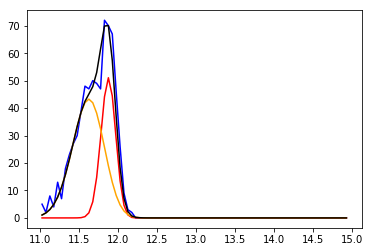

In [318]:
#manually fit the LOFAR data to give a rough idea of the parameters

mask = ~np.isnan(lofar_cigale['spire_250'])
z = lofar_cigale['redshift'][mask]
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_250 = np.log10(lofar_cigale['bayes.dust.luminosity'][mask] / 3.8E26)
lum_250_lim = np.log10(5*1E-3*1E-26  *4*np.pi*dist**2)
lum_rad = np.log10(lofar_cigale['Total_flux'][mask]*4*np.pi*dist**2 * 1E-26)
flag_250 = lofar_cigale['flag_spire_250'][mask]

mask = (lum_rad >24) & (lum_rad<24.25)
lum_250 = lum_250[mask]
flag_250 = flag_250[mask]

bins = np.arange(11,15,0.05)
q_plot,_ = np.histogram(lum_250,bins=bins)
x = get_center(bins)
y = q_plot
plt.plot(x,y,c='blue')

#x = np.arange(-3,3,0.01)
y1 = log_normal(x,[-1.14,0.03,15])*12
plt.plot(x,y1,c='red')

#x = np.arange(-3,3,0.01)
y2 = log_normal(x,[-1.22,0.06,15])*22
plt.plot(x,y2,c='orange')

y = y1+y2
plt.plot(x,y,c='black')
plt.show()

In [272]:
# define the FIRC model as a combination of two log normal distributions 
mu_sf = -1.14
sigma_sf = 0.03
theta_sf = 15
sf_params = [mu_sf,sigma_sf,theta_sf] 

mu_agn = -1.22
sigma_agn = 0.06
theta_agn = 15
agn_params = [mu_agn,sigma_agn,theta_agn]

sf_frac = 0.5

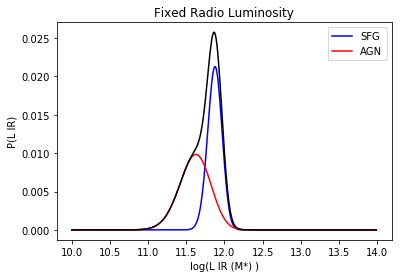

In [358]:
#plot the model for a given Lradio

Lradio = 24.125
binwidth = 0.01
x = np.arange(10,14,binwidth)

y_sf = log_normal(x,[mu_sf,sigma_sf,theta_sf])*sf_frac*binwidth
plt.plot(x,y_sf,c='blue',label='SFG')

y_agn = log_normal(x,[mu_agn,sigma_agn,theta_agn])*(1-sf_frac)*binwidth
plt.plot(x,y_agn,c='red',label='AGN')

plt.plot(x,y_agn+y_sf,c='black')
plt.xlabel('log(L IR (M*) )')
plt.ylabel('P(L IR)')
plt.title('Fixed Radio Luminosity')
plt.legend()
plt.show()

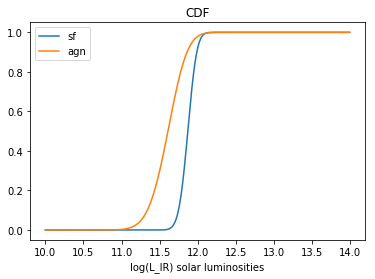

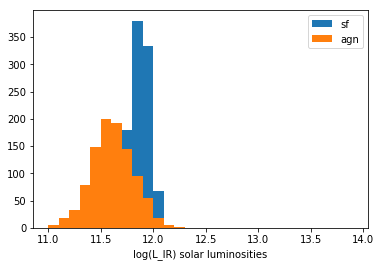

In [275]:
#generate L_FIR for galaxies

#create CDF from the PDF's to draw L FIR from
CDF_sf = np.cumsum(y_sf/sf_frac)
CDF_agn = np.cumsum(y_agn/(1-sf_frac))
plt.plot(x,CDF_sf,label='sf')
plt.plot(x,CDF_agn,label='agn')
plt.xlabel('log(L_IR) solar luminosities')
plt.title('CDF')
plt.legend()
plt.show()

n_sf = 1000
tmp = np.random.rand(n_sf)
L_IR_sf = np.round(np.interp(tmp,CDF_sf,x),2)
n_agn = 1000
tmp = np.random.rand(n_agn)
L_IR_agn = np.round(np.interp(tmp,CDF_agn,x),2)

bins = np.arange(11,14,0.1)
plt.hist(L_IR_sf,bins=bins,label='sf')
plt.hist(L_IR_agn,bins=bins,label='agn')
plt.xlabel('log(L_IR) solar luminosities')

#plt.plot(x,(y_agn+y_sf)*20000,c='black')

plt.legend()
plt.show()

## Setup the MCMC to fit a model to this data

In [324]:
def lnprior(theta,PRIORS):

    P = np.zeros(len(theta))

    for i,p in enumerate(params):
        if ( PRIORS[p][0]<= theta[i] <= PRIORS[p][1] ): 
            P[i] = 1.0
        else:
            P[i] = 0.0
            
#    if theta[0]<theta[2]:
#        P[0] = 0.0
            
    # return the log of the probability, in this case either log of 1 or 0.
    if np.product(P) == 0.0: 
        return(-np.inf)
        #return(0.0)
    else: 
        return(0.0)
        #return(1.0)
    
def lnlike(theta,x,location):
    #return(-0.5*sum( ( y-model( x, theta  ) )**2))
    #plt.scatter(x,y)
    #plt.plot(x,model(x,theta))
    #plt.show()
    
    if len(x)==0:
        return(0)
    
    mean_sf,sigma_sf,mean_agn,sigma_agn,sf_frac = theta
    params_sf  = [mean_sf,sigma_sf,location]
    params_agn = [mean_agn,sigma_agn,location]
    
    model = sf_frac*log_normal(x,params_sf) + (1-sf_frac)*log_normal(x,params_agn)
    

    lnlike = np.log10(model*0.01)
    lnlike = np.sum(lnlike)
    #print('lnlike is: {}'.format(lnlike))
    if np.isnan(lnlike)==True:
        lnlike = -np.inf

    if np.sum(lnlike>0):
        print(theta)
    return(lnlike)
    
def lnmissing(theta,x_y_mis,theta_sel,location):
    
    theta_sf = [theta[0],theta[1],location]
    theta_agn = [theta[2],theta[3],location]
    binwidth = 0.01
    x = np.arange(11,15,binwidth)

    model_sf = log_normal(x,theta_sf)*binwidth
    model_agn = log_normal(x,theta_agn)*binwidth
    selection_function = 1-gaus_cdf(x,theta_sel)
    prob_mis = np.sum((model_sf+model_agn)*selection_function)
    prob_mis = np.log10(prob_mis)*len(x_y_mis)
    
    lnmissing = prob_mis
    return(lnmissing)

def find_pdf_normalisation(theta,x,y,theta_rng):
    m_sf,c_sf,sig_sf,m_agn,c_agn,sig_agn,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9 = theta
    params_sf  = [m_sf,c_sf,sig_sf]
    params_agn = [m_agn,c_agn,sig_agn]
    sf_prop = np.array([sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9])
    rad_lum_low,rad_lum_up,fir_lum_low,fir_lum_up = theta_rng
    
    xrng = np.arange(20,30,0.1)
    yrng = np.arange(0,25,0.1)
    xbin,ybin = np.meshgrid(xrng,yrng)
    which_sf_prop = np.digitize(xrng,bins=np.arange(20,30,1))
    model_fit = sf_prop[which_sf_prop-1]*straight_line_gaus(xbin,ybin,params_sf) + (1-sf_prop[which_sf_prop-1])*straight_line_gaus(xbin,ybin,params_agn)
    int_first = np.trapz(model_fit,dx=0.1,axis=0)
    model_volume = np.trapz(int_first,dx=0.1)
    print('normalisation is is: {}'.format(model_volume))
    return(model_volume)

def lnprob_no_missing(theta,x,location,PRIORS):
    
    lp = lnprior(theta,PRIORS)
    ll = lnlike(theta,x,location)

    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf
    else:
        return lp + ll
    
def lnprob(theta,x,x_y_mis,theta_sel,location,PRIORS):
    

    #print(theta)
    lp = lnprior(theta,PRIORS)
    #print('lp is: {}'.format(lp))
    ll = lnlike(theta,x,location)
    #print('ll is: {}'.format(ll))
    lm = lnmissing(theta,x_y_mis,theta_sel,location)
    #print('lm is: {}'.format(lm))

    if not np.isfinite(lp) or not np.isfinite(ll) or not np.isfinite(lm):
        return -np.inf
    if np.isnan(lp) or np.isnan(ll) or np.isnan(lm):
        return -np.inf
    else:
        #print('likelihood is: {}'.format(lp + ll + lm))
        return lp + ll + lm

In [325]:
params = ['mean_sf','sigma_sf','mean_agn','sigma_agn','sf_frac']
PRIORS = {     'mean_sf'   :  [ -2   ,   0 ] ,
               'sigma_sf'   :  [0.001,0.5],
               'mean_agn'    :  [  -2   ,    0 ] ,
               'sigma_agn'    :  [  0.001   ,    0.5 ] ,
          'sf_frac'   :  [0.0,1.0]}

nwalkers = 40  # number of individual chains to make
ndim     = len(params) # number of dimensions
preburns = 1200  # length of "burn-in" period to be discarded
burns    = 1800 # number of iterations to be used after initial burn-in.

In [379]:
xdata = np.concatenate((L_IR_sf,L_IR_agn))
x_y_mis = 0
location = 15

pos = np.zeros((nwalkers,ndim))
for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = np.random.rand(nwalkers)*(PRIORS[params[j]][1]-PRIORS[params[j]][0]) + PRIORS[params[j]][0]


sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob_no_missing, args=[xdata,location,PRIORS] )

time0 = time.time()
print('MCMC start ')

pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)

time0 = time.time()
print('MCMC start ')
mask = prob==np.max(prob)
pos_new = pos[mask]

pos = np.zeros((nwalkers,ndim))
for n in range(nwalkers):
    pos[n,:] = pos_new

for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = pos[:,j] + np.random.normal(0,(PRIORS[params[j]][1]-PRIORS[params[j]][0])/100,nwalkers)

sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob_no_missing, args=[xdata,location,PRIORS] )
pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]

MCMC start 


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


MCMC end, Time taken:  55.281516790390015
MCMC start 
MCMC end, Time taken:  55.97489786148071


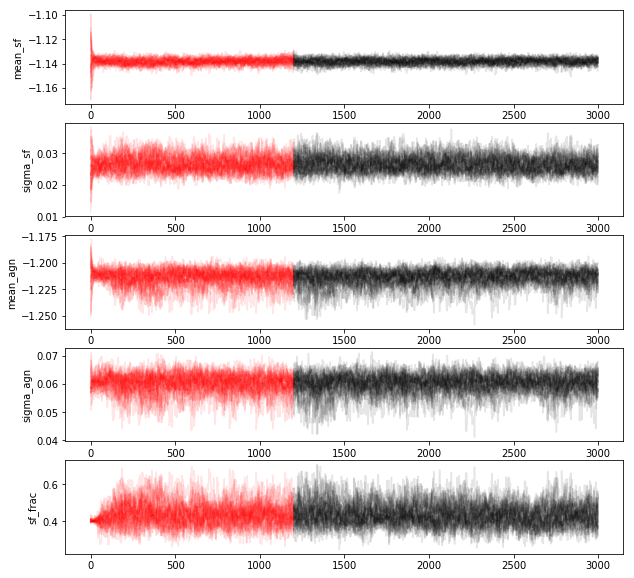

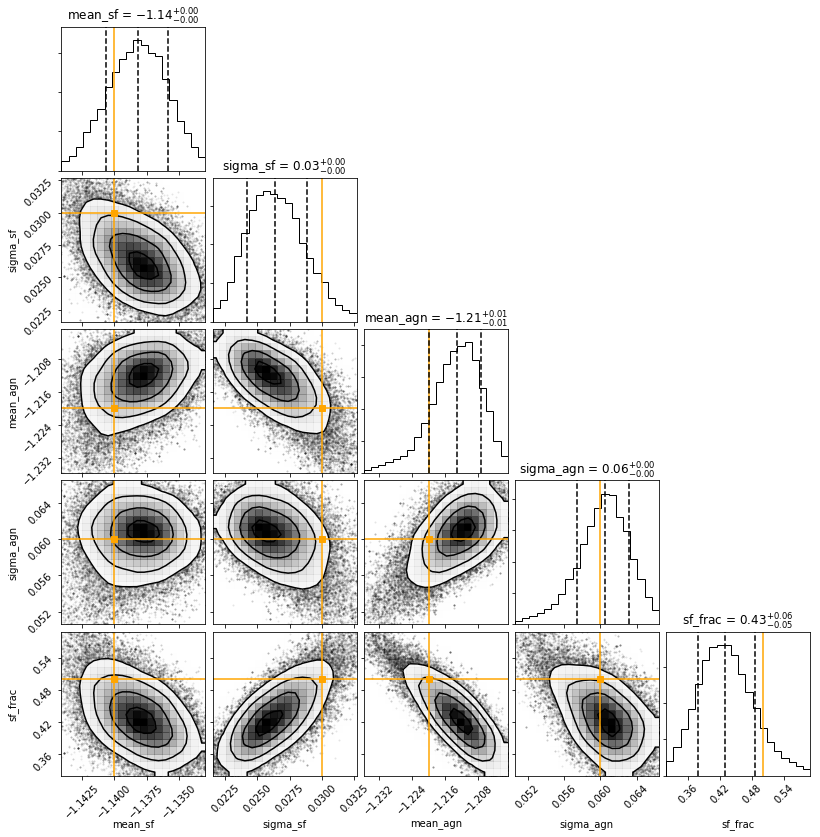

In [380]:
theta_true = np.array([mu_sf,sigma_sf,mu_agn,sigma_agn,sf_frac])
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

fig2,axarr = plt.subplots( ndim,1 ,figsize=(10,10))

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot( np.arange(0, preburns ,1) , sampler.chain[i,:preburns,j] , alpha=0.1, color='r' )
        axarr[j].plot( np.arange(preburns, burns+preburns ,1) , sampler.chain[i,preburns:,j] , alpha=0.1, color='k' )

    axarr[j].set_ylabel( params[j] )


mask = [np.array([samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2]]) for i in range(nwalkers*burns) ]

#[mask].reshape(int(len(samples[mask])/len(params)),len(params))
import corner
fig = corner.corner(samples, labels= params , truths = theta_true, truth_color='orange', show_titles=True,\
        quantiles=[.16,.50,.84], smooth=1.0, \
        #range = [(PRIORS[i][0],PRIORS[i][1]) for i in params])
        range = [(np.percentile(samples[:,i],1),np.percentile(samples[:,i],99)) for i in range(ndim)])

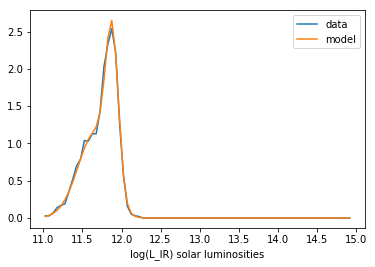

lnprob of median params is: -3768.899362815293
lnprob of true params is: -3770.8963392152027


In [381]:
bins=np.arange(11,15,0.05)
y,_ = np.histogram(xdata,bins=bins)
x = get_center(bins)
plt.plot(x,y/len(xdata)/0.05,label='data')

y_sf = log_normal(x,[median_params[0],median_params[1],location])*median_params[4]
y_agn = log_normal(x,[median_params[2],median_params[3],location])*(1-median_params[4])
plt.plot(x,(y_agn+y_sf),label='model')
y_sf = log_normal(x,[theta_true[0],theta_true[1],location])*median_params[4]
y_agn = log_normal(x,[theta_true[2],theta_true[3],location])*(1-median_params[4])
#plt.plot(x,(y_agn+y_sf),label='model')

plt.xlabel('log(L_IR) solar luminosities')
plt.legend()
plt.show()
lnprob_measured = lnprob_no_missing(median_params,xdata,location,PRIORS)
print('lnprob of median params is: {}'.format(lnprob_measured))
lnprob_measured = lnprob_no_missing(theta_true,xdata,location,PRIORS)
print('lnprob of true params is: {}'.format(lnprob_measured))

## Now add in selection effects  causing missing data

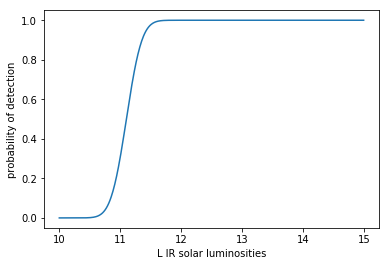

1966 sources are detected this is 98.3% of the sample
percentage of AGN detected is: 96.6
percentage of SF detected is: 100.0
SF fraction of detected galaxies is: 0.508646998982706


In [382]:
# create detection flag
theta_sel = [11.1,0.2]
x = np.arange(10,15,0.01)
y = gaus_cdf(x,theta_sel)
plt.plot(x,y)
plt.ylabel('probability of detection')
plt.xlabel('L IR solar luminosities')
plt.show()

det = np.random.rand(len(xdata))
prob_det = np.interp(xdata,x,y)
detection = prob_det>det
print('{} sources are detected this is {}% of the sample'.format(np.sum(detection),np.sum(detection)/len(xdata)*100))
print('percentage of AGN detected is: {}'.format(np.sum(detection[1000:])/n_agn*100))
print('percentage of SF detected is: {}'.format(np.sum(detection[:1000])/n_sf*100))
print('SF fraction of detected galaxies is: {}'.format(np.sum(detection[:1000])/np.sum(detection)))

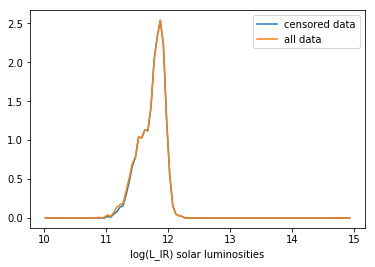

In [383]:
binwidth = 0.05
bins=np.arange(10,15,binwidth)
x = get_center(bins)

y,_ = np.histogram(xdata[detection],bins=bins)
plt.plot(x,y/len(xdata)/binwidth,label='censored data')

y,_ = np.histogram(xdata,bins=bins)
plt.plot(x,y/len(xdata)/binwidth,label='all data')
plt.xlabel('log(L_IR) solar luminosities')
plt.legend()
plt.show()

## Run MCMC fitting where all starting positions are in the allowed region

In [384]:
xdata_censored = xdata[detection]
x_y_mis = xdata[~detection]
location = 15

pos = np.zeros((nwalkers,ndim))
for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = np.random.rand(nwalkers)*(PRIORS[params[j]][1]-PRIORS[params[j]][0]) + PRIORS[params[j]][0]

for n,starting in enumerate(pos):
    if pos[n,0]<pos[n,2]:
        pos[n,0] = pos[n,2]*1.01


sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[xdata_censored,x_y_mis,theta_sel,location,PRIORS] )

time0 = time.time()
print('MCMC start ')

pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]
error_u_params = [np.percentile(samples[:,i],84) for i in range(ndim)]
error_l_params = [np.percentile(samples[:,i],16) for i in range(ndim)]
error_params = [(error_u_params[i] - error_l_params[i])/2 for i in range(ndim)]

MCMC start 


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log10
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


MCMC end, Time taken:  84.8980004787445


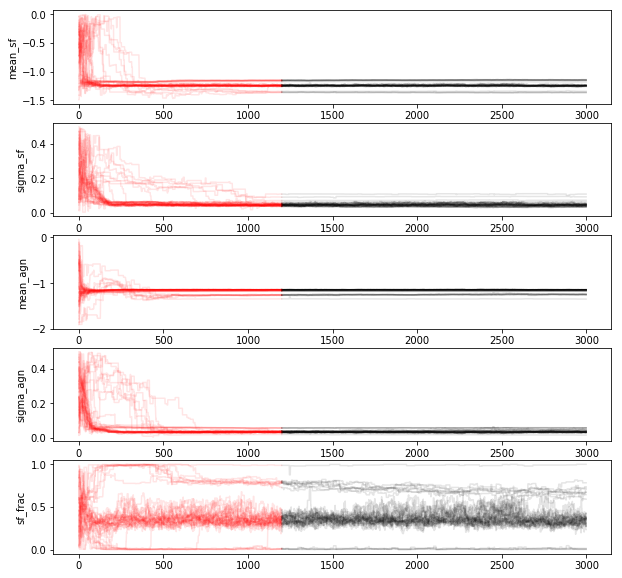

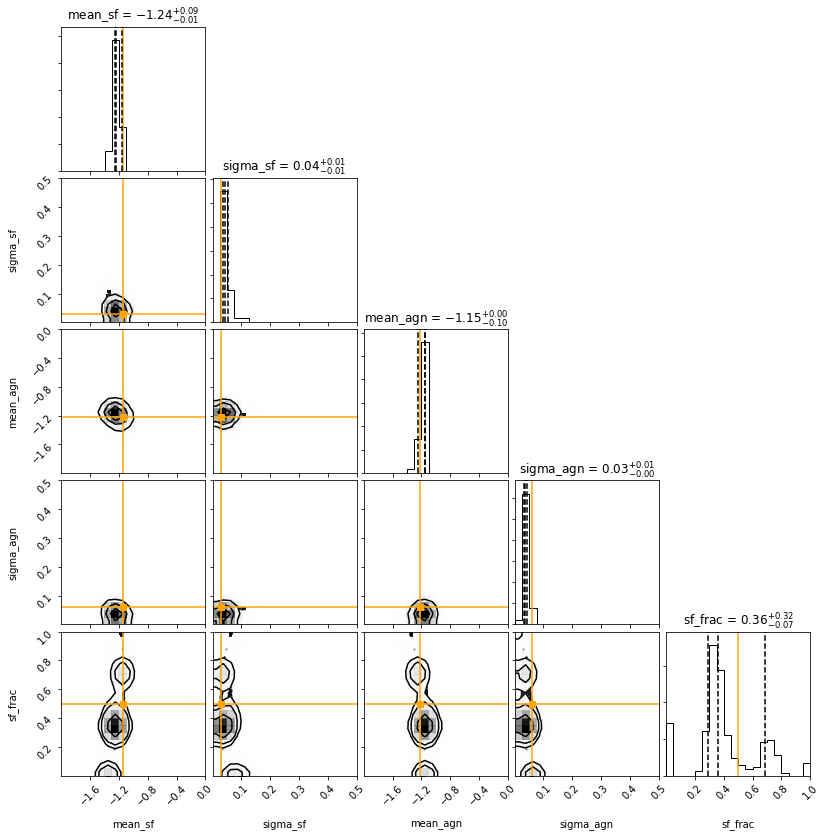

In [385]:
theta_true = np.array([mu_sf,sigma_sf,mu_agn,sigma_agn,sf_frac])
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

fig2,axarr = plt.subplots( ndim,1 ,figsize=(10,10))

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot( np.arange(0, preburns ,1) , sampler.chain[i,:preburns,j] , alpha=0.1, color='r' )
        axarr[j].plot( np.arange(preburns, burns+preburns ,1) , sampler.chain[i,preburns:,j] , alpha=0.1, color='k' )

    axarr[j].set_ylabel( params[j] )


mask = [np.array([samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2]]) for i in range(nwalkers*burns) ]

#[mask].reshape(int(len(samples[mask])/len(params)),len(params))
import corner
fig = corner.corner(samples, labels= params , truths = theta_true, truth_color='orange', show_titles=True,\
        quantiles=[.16,.50,.84], smooth=1.0, \
        range = [(PRIORS[i][0],PRIORS[i][1]) for i in params])

mean_sf true value is: -1.14 : measured value is: -1.241948193702108+-0.05141810808606273
sigma_sf true value is: 0.03 : measured value is: 0.044661338271641045+-0.00957448952468836
mean_agn true value is: -1.22 : measured value is: -1.1471447419333338+-0.052266158634447724
sigma_agn true value is: 0.06 : measured value is: 0.03443576544286789+-0.005832658939204262
sf_frac true value is: 0.5 : measured value is: 0.36262297544868577+-0.19760316895064106


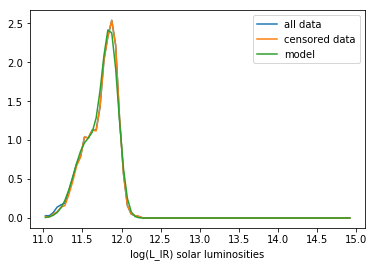

lnprob of median params is: -3724.5847326185994
lnprob of median params is: -3726.1321835289364


In [386]:
for n,name in enumerate(params):
    true = theta_true[n]
    measured = median_params[n]
    error = error_params[n]
    print('{} true value is: {} : measured value is: {}+-{}'.format(name,true,measured,error))

bins=np.arange(11,15,0.05)
x = get_center(bins)
y,_ = np.histogram(xdata,bins=bins)
plt.plot(x,y/len(xdata)/0.05,label='all data')

y,_ = np.histogram(xdata[detection],bins=bins)
plt.plot(x,y/len(xdata)/0.05,label='censored data')

sf_frac_tmp = median_params[4]
#sf_frac_tmp = 0.5

y_sf = log_normal(x,[median_params[0],median_params[1],location])*sf_frac_tmp
y_agn = log_normal(x,[median_params[2],median_params[3],location])*(1-sf_frac_tmp)
plt.plot(x,(y_agn+y_sf),label='model')
plt.xlabel('log(L_IR) solar luminosities')
plt.legend()
plt.show()
lnprob_measured = lnprob(median_params,xdata_censored,x_y_mis,theta_sel,location,PRIORS)
print('lnprob of median params is: {}'.format(lnprob_measured))
lnprob_true = lnprob(theta_true,xdata_censored,x_y_mis,theta_sel,location,PRIORS)
print('lnprob of median params is: {}'.format(lnprob_true))

## Run MCMC where the starting position are randomised

In [401]:
xdata_censored = xdata[detection]
x_y_mis = xdata[~detection]
location = 15

pos = np.zeros((nwalkers,ndim))
for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = np.random.rand(nwalkers)*(PRIORS[params[j]][1]-PRIORS[params[j]][0]) + PRIORS[params[j]][0]

sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[xdata_censored,x_y_mis,theta_sel,location,PRIORS] )

time0 = time.time()
print('MCMC start ')

pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

#sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[xdata_censored,x_y_mis,theta_sel,location,PRIORS] )

mask = prob==np.max(prob)
pos_new = pos[mask]
print(pos_new)
print(lnprob(pos_new[0],xdata_censored,x_y_mis,theta_sel,location,PRIORS))
pos = np.zeros((nwalkers,ndim))
for n in range(nwalkers):
    pos[n,:] = pos_new

for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = pos[:,j] + np.random.normal(0,(PRIORS[params[j]][1]-PRIORS[params[j]][0])/50,nwalkers)

sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[xdata_censored,x_y_mis,theta_sel,location,PRIORS] )
pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]
error_u_params = [np.percentile(samples[:,i],84) for i in range(ndim)]
error_l_params = [np.percentile(samples[:,i],16) for i in range(ndim)]
error_params = [(error_u_params[i] - error_l_params[i])/2 for i in range(ndim)]

MCMC start 


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log10
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


[[-1.14457054  0.03406945 -1.24305409  0.04657321  0.64382605]]
-3723.1028552963458
MCMC end, Time taken:  168.139146566391


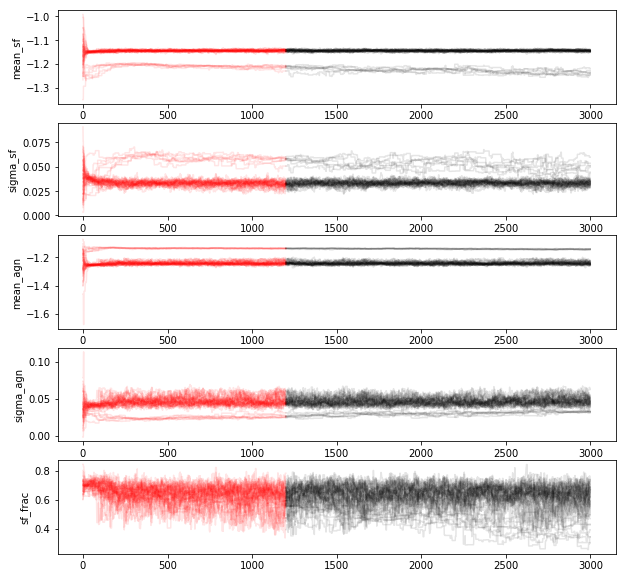

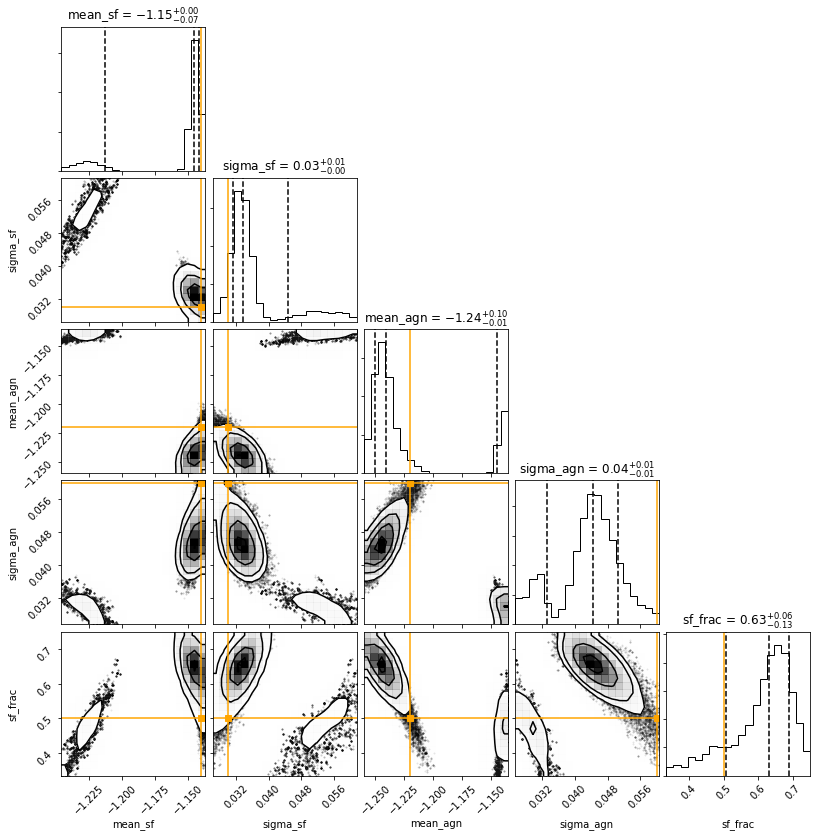

In [399]:
theta_true = np.array([mu_sf,sigma_sf,mu_agn,sigma_agn,sf_frac])
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

fig2,axarr = plt.subplots( ndim,1 ,figsize=(10,10))

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot( np.arange(0, preburns ,1) , sampler.chain[i,:preburns,j] , alpha=0.1, color='r' )
        axarr[j].plot( np.arange(preburns, burns+preburns ,1) , sampler.chain[i,preburns:,j] , alpha=0.1, color='k' )

    axarr[j].set_ylabel( params[j] )


mask = [np.array([samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2]]) for i in range(nwalkers*burns) ]

#[mask].reshape(int(len(samples[mask])/len(params)),len(params))
import corner
fig = corner.corner(samples, labels= params , truths = theta_true, truth_color='orange', show_titles=True,\
        quantiles=[.16,.50,.84], smooth=1.0, \
        #range = [(PRIORS[i][0],PRIORS[i][1]) for i in params])
        range = [(np.percentile(samples[:,i],1),np.percentile(samples[:,i],99)) for i in range(ndim)])

mean_sf true value is: -1.14 : measured value is: -1.1457436249729476+-0.03544950801374758
sigma_sf true value is: 0.03 : measured value is: 0.033786654376231046+-0.00680069258599874
mean_agn true value is: -1.22 : measured value is: -1.241055140630965+-0.05270518574002325
sigma_agn true value is: 0.06 : measured value is: 0.04443405866423911+-0.008620095142583412
sf_frac true value is: 0.5 : measured value is: 0.6319952863640332+-0.09189170962799725


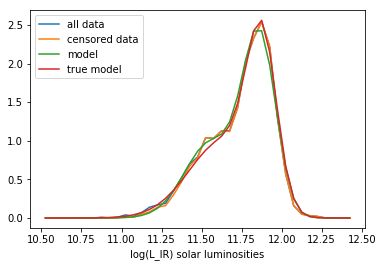

lnprob of median params is: -3723.8629870295845
lnprob of true params is: -3726.1321835289364


In [400]:
for n,name in enumerate(params):
    true = theta_true[n]
    measured = median_params[n]
    error = error_params[n]
    print('{} true value is: {} : measured value is: {}+-{}'.format(name,true,measured,error))

bins=np.arange(10.5,12.5,0.05)
x = get_center(bins)
y,_ = np.histogram(xdata,bins=bins)
plt.plot(x,y/len(xdata)/0.05,label='all data')

y,_ = np.histogram(xdata[detection],bins=bins)
plt.plot(x,y/len(xdata)/0.05,label='censored data')

sf_frac_tmp = median_params[4]
#sf_frac_tmp = 0.5

y_sf = log_normal(x,[median_params[0],median_params[1],location])*(sf_frac_tmp)
y_agn = log_normal(x,[median_params[2],median_params[3],location])*(1-sf_frac_tmp)
plt.plot(x,(y_agn+y_sf),label='model')
y_sf = log_normal(x,[theta_true[2],theta_true[3],location])*(1-theta_true[4])
y_agn = log_normal(x,[theta_true[0],theta_true[1],location])*(theta_true[4])
plt.plot(x,(y_agn+y_sf),label='true model')
plt.xlabel('log(L_IR) solar luminosities')
plt.legend()
plt.show()
lnprob_measured = lnprob(median_params,xdata_censored,x_y_mis,theta_sel,location,PRIORS)
print('lnprob of median params is: {}'.format(lnprob_measured))
lnprob_measured = lnprob(theta_true,xdata_censored,x_y_mis,theta_sel,location,PRIORS)
print('lnprob of true params is: {}'.format(lnprob_measured))

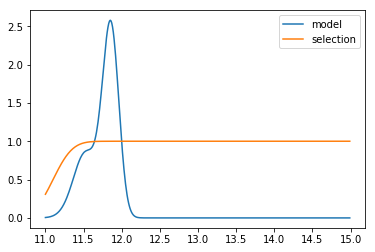

In [314]:
x = np.arange(11,15,0.01)
sf = median_params[4]*log_normal(x,[median_params[0],median_params[1],location])
agn = log_normal(x,[median_params[2],median_params[3],location]) * (1-median_params[4])
model =  agn + sf
sel = gaus_cdf(x,theta_sel)

plt.plot(x,model,label='model')
plt.plot(x,sel,label='selection')

plt.legend()
plt.show()

## Now lets try this on the real data from LOFAR and Herschel

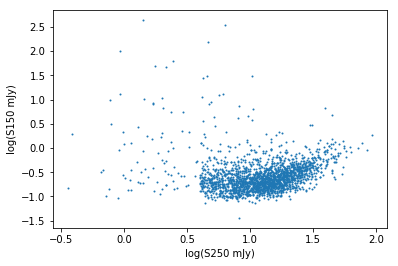

In [17]:
f250 = np.log10(lofar_cigale['spire_250'][~lofar_cigale['flag_spire_250']])
frad = np.log10(lofar_cigale['Total_flux'][~lofar_cigale['flag_spire_250']]) + 3
plt.scatter(f250,frad,s=1)
#plt.plot([-1.5,2.0],[-1.5,2.0],c='black')

x = np.arange(-1.5,2.0,0.1)
y = 1.15*x #- 5.05
#plt.plot(x,y)
plt.xlabel('log(S250 mJy)')
plt.ylabel('log(S150 mJy)')
plt.show()

In [23]:
(np.nan<0.5) | False

False

In [18]:
mask = np.log10(lofar_cigale['spire_250'])<7.0
lofar_cigale[mask]

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


id,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,MegaCam.u.res,MegaCam.u.res_err,PS1.g.res,PS1.g.res_err,PS1.r.res,PS1.r.res_err,PS1.i.res,PS1.i.res_err,PS1.z.res,PS1.z.res_err,PS1.y.res,PS1.y.res_err,HSC-g_mod.res,HSC-g_mod.res_err,HSC-r_mod.res,HSC-r_mod.res_err,HSC-i_mod.res,HSC-i_mod.res_err,HSC-z_mod.res,HSC-z_mod.res_err,HSC-Y_mod.res,HSC-Y_mod.res_err,wHSC-NB921_mod.res,wHSC-NB921_mod.res_err,UKIDSS.J.res,UKIDSS.J.res_err,UKIDSS.K.res,UKIDSS.K.res_err,IRAC.I1.res,IRAC.I1.res_err,IRAC.I2.res,IRAC.I2.res_err,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,IRAC.I3.res,IRAC.I3.res_err,IRAC.I4.res,IRAC.I4.res_err,mips_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,pacs_green,FErr_PACS_100_u,FErr_PACS_100_l,pacs_red,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,spire_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,spire_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,spire_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,redshift,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster,mips_24_err,pacs_green_err,pacs_red_err,spire_250_err,spire_350_err,spire_500_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.dust.mass,bayes.dust.mass_err,bayes.dust.qpah,bayes.dust.qpah_err,bayes.dust.umin,bayes.dust.umin_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.attenuation.Av_BC,bayes.attenuation.Av_BC_err,bayes.attenuation.bessell_b,bayes.attenuation.bessell_b_err,bayes.attenuation.galex_fuv,bayes.attenuation.galex_fuv_err,bayes.attenuation.slope_BC,bayes.attenuation.slope_BC_err,bayes.attenuation.BC_to_ISM_factor,bayes.attenuation.BC_to_ISM_factor_err,bayes.attenuation.slope_ISM,bayes.attenuation.slope_ISM_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.burst_age,bayes.sfh.burst_age_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,best.chi_square,best.reduced_chi_square,best.agn.agn_luminosity,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.luminosity,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.scatt_luminosity,best.agn.tau,best.agn.therm_luminosity,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.st

In [327]:
# The data was already loaded in at the start of the notebook
xdata_censored = np.round(lum_250[~flag_250],2)
print('there are {} observed galaxies'.format(len(xdata_censored)))
x_y_mis = lum_250[flag_250]
print('there are {} observed galaxies with non detection in the FIR'.format(len(x_y_mis)))

# The selection function can be found in selection_function.ipynb
theta_sel = [38.18-np.log10(3.8E26),0.16]

there are 554 observed galaxies
there are 166 observed galaxies with non detection in the FIR


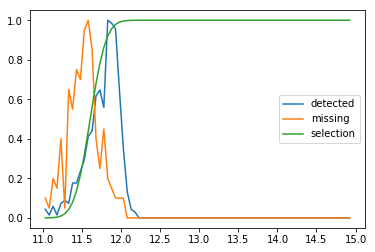

In [322]:
bins = np.arange(11,15,0.05)
y,_ = np.histogram(xdata_censored,bins=bins)
x = get_center(bins)
plt.plot(x,y/np.max(y),label='detected')

y,_ = np.histogram(x_y_mis,bins=bins)
x = get_center(bins)
plt.plot(x,y/np.max(y),label='missing')

bins=np.arange(11,15,0.01)
y = gaus_cdf(x,theta_sel)
plt.plot(x,y,label='selection')

plt.legend()
plt.show()

In [331]:
#real_det = lofar_cigale['flag_250_spire']
#xdata_censored = lofar_cigale['bayes.dustluminosity']
#x_y_mis = xdata[~detection]
location = 15

pos = np.zeros((nwalkers,ndim))
for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = np.random.rand(nwalkers)*(PRIORS[params[j]][1]-PRIORS[params[j]][0]) + PRIORS[params[j]][0]

sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[xdata_censored,x_y_mis,theta_sel,location,PRIORS] )

time0 = time.time()
print('MCMC start ')

pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

#sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[xdata_censored,x_y_mis,theta_sel,location,PRIORS] )
time1=time.time()
print('MCMC end, Time taken: ',time1-time0)

time0 = time.time()
print('MCMC start ')

mask = prob==np.max(prob)
pos_new = pos[mask]
print(lnprob(pos_new[0],xdata_censored,x_y_mis,theta_sel,location,PRIORS))
pos = np.zeros((nwalkers,ndim))
for n in range(nwalkers):
    pos[n,:] = pos_new

for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = pos[:,j] + np.random.normal(0,(PRIORS[params[j]][1]-PRIORS[params[j]][0])/100,nwalkers)

sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[xdata_censored,x_y_mis,theta_sel,location,PRIORS] )
pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)

samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]
error_u_params = [np.percentile(samples[:,i],84) for i in range(ndim)]
error_l_params = [np.percentile(samples[:,i],16) for i in range(ndim)]
error_params = [(error_u_params[i] - error_l_params[i])/2 for i in range(ndim)]

MCMC start 


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log10


MCMC end, Time taken:  722.440417766571
MCMC start 
-1062.1463611980832


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


MCMC end, Time taken:  720.5175914764404


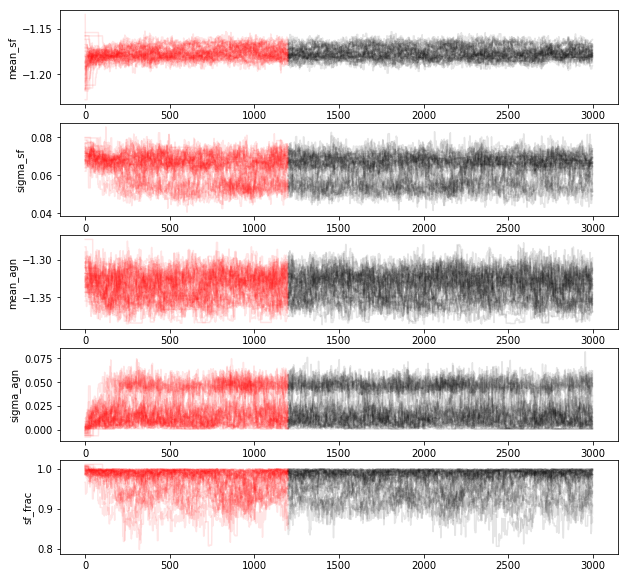

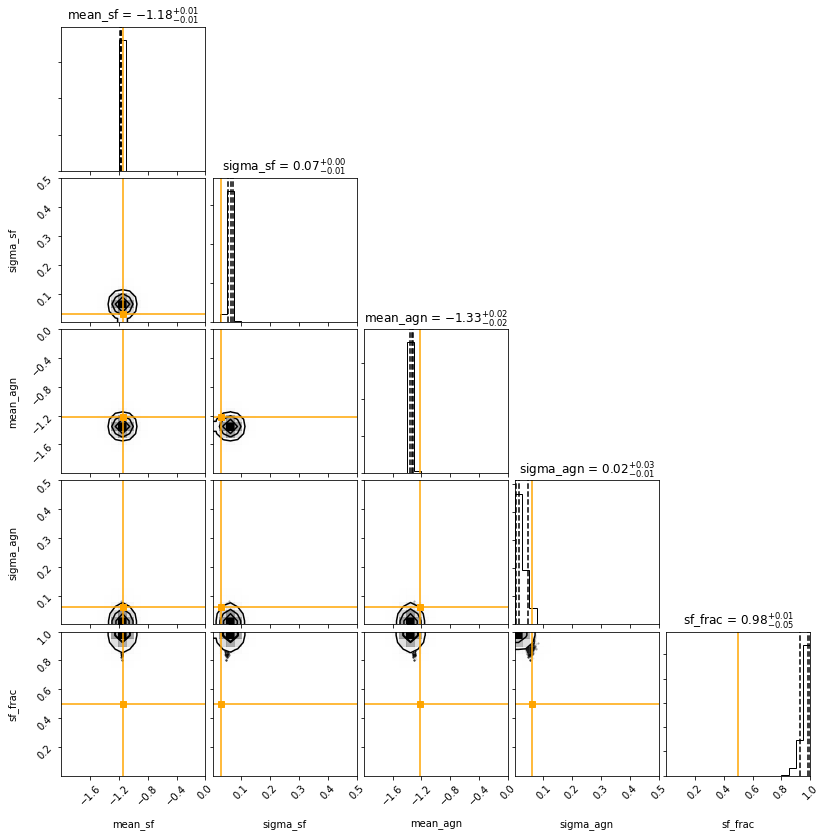

In [332]:
theta_true = np.array([mu_sf,sigma_sf,mu_agn,sigma_agn,sf_frac])
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

fig2,axarr = plt.subplots( ndim,1 ,figsize=(10,10))

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot( np.arange(0, preburns ,1) , sampler.chain[i,:preburns,j] , alpha=0.1, color='r' )
        axarr[j].plot( np.arange(preburns, burns+preburns ,1) , sampler.chain[i,preburns:,j] , alpha=0.1, color='k' )

    axarr[j].set_ylabel( params[j] )


mask = [np.array([samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2],samples[i,0]>samples[i,2]]) for i in range(nwalkers*burns) ]

#[mask].reshape(int(len(samples[mask])/len(params)),len(params))
import corner
fig = corner.corner(samples, labels= params , truths = theta_true, truth_color='orange', show_titles=True,\
        quantiles=[.16,.50,.84], smooth=1.0, \
        range = [(PRIORS[i][0],PRIORS[i][1]) for i in params])

mean_sf true value is: -1.14 : measured value is: -1.1775693327685466+-0.0073617904554591496
sigma_sf true value is: 0.03 : measured value is: 0.06582743771073496+-0.008121338871752301
mean_agn true value is: -1.22 : measured value is: -1.3336166303869417+-0.019769001234529848
sigma_agn true value is: 0.06 : measured value is: 0.016601719633569198+-0.020729746704748645
sf_frac true value is: 0.5 : measured value is: 0.9840965361738289+-0.03297037417933346


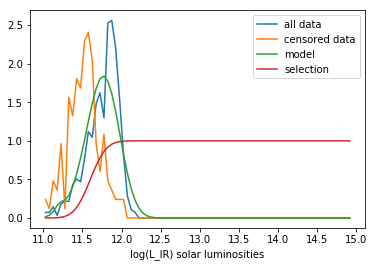

lnprob of median params is: -1068.33396234608
lnprob of true params is: -1113.6118821941373


In [333]:
for n,name in enumerate(params):
    true = theta_true[n]
    measured = median_params[n]
    error = error_params[n]
    print('{} true value is: {} : measured value is: {}+-{}'.format(name,true,measured,error))

bins=np.arange(11,15,0.05)
x = get_center(bins)
y,_ = np.histogram(xdata_censored,bins=bins)
plt.plot(x,y/len(xdata_censored)/0.05,label='all data')

y,_ = np.histogram(x_y_mis,bins=bins)
plt.plot(x,y/len(x_y_mis)/0.05,label='censored data')

sf_frac_tmp = median_params[4]
#sf_frac_tmp = 0.7

y_sf = log_normal(x,[median_params[0],median_params[1],location])*sf_frac_tmp
y_agn = log_normal(x,[median_params[2],median_params[3],location])*(1-sf_frac_tmp)
plt.plot(x,(y_agn+y_sf),label='model')
plt.xlabel('log(L_IR) solar luminosities')

bins=np.arange(11,15,0.01)
y = gaus_cdf(x,theta_sel)
plt.plot(x,y,label='selection')

plt.legend()
plt.show()
lnprob_measured = lnprob(median_params,xdata_censored,x_y_mis,theta_sel,location,PRIORS)
print('lnprob of median params is: {}'.format(lnprob_measured))
lnprob_measured = lnprob(theta_true,xdata_censored,x_y_mis,theta_sel,location,PRIORS)
print('lnprob of true params is: {}'.format(lnprob_measured))